In [2]:
import numpy as np
import pandas as pd
import os

pd.options.display.max_colwidth = 1000

In [3]:
csv_save_dir = 'output_csvs_new'
if not os.path.exists(csv_save_dir):
    os.makedirs(csv_save_dir)

In [4]:
%%time

# Read information for the new records
records = pd.read_csv('new-citations-rerun.tsv', sep='\t', header=None)
records.columns = ['recID', 'oldRef', 'newRef', 'metaData']

print('Total Records: {}'.format(len(records)))

Total Records: 30230936
CPU times: user 2min 41s, sys: 9.49 s, total: 2min 50s
Wall time: 2min 53s


In [5]:
# Read the new citation counts
labs = pd.read_csv('new-citation-counts-rerun.tsv', sep='\t', header=None)
labs.columns = ['recID', 'Citation_Difference']
# Citation_Difference is actually citation count but is used here for ease later when subtracting

# Index by recIDs
labs_indexed = labs.set_index('recID')

In [6]:
# Read the legacy citation counts
legacy = pd.read_csv('old-citation-counts.tsv', sep='\t')
legacy.columns = ['recID', 'Citation_Difference']
# Citation_Difference is actually citation count but is used here for ease later when subtracting

# Index by recrod IDs
legacy_indexed = legacy.set_index('recID')

In [7]:
# Compute the difference in citation counts between Labs and Legacy
diff = labs_indexed - legacy_indexed

In [8]:
# Filter out the NaNs
is_nan = diff.Citation_Difference.isna()
NaN_entries = diff[is_nan]

print('{} articles are differently indexed between the legacy and labs records and have no correspondence'.format(len(NaN_entries)))

11434 articles are differently indexed between the legacy and labs records and have no correspondence


In [9]:
# Filter the valid entries
is_valid = ~diff.Citation_Difference.isna()
valid_diff = diff[is_valid]

In [10]:
# Get the articles which have lost citations
lost = valid_diff.Citation_Difference < 0
lost_citations = valid_diff[lost]

# Sort the list
lost_citations = lost_citations.sort_values('Citation_Difference')

In [11]:
# Get the articles which have gained citations
gained = valid_diff.Citation_Difference > 0
gained_citations = valid_diff[gained]

# Sort the list
gained_citations = gained_citations.sort_values('Citation_Difference', ascending=False)

In [12]:
# Get the counts for absolute differences in citation numbers
abs_diff = np.abs(valid_diff)
abs_diff = abs_diff.sort_values('Citation_Difference', ascending=False)

# Filter out the zero difference entries
non_zero_diff = abs_diff.Citation_Difference != 0
abs_diff = abs_diff[non_zero_diff]

In [13]:
# Initialize extended DataFrames for the differences
lost_citations_ext = lost_citations
gained_citations_ext = gained_citations
abs_diff_ext = abs_diff

# For lost citations
lost_citations_ext['Legacy_Count'] = legacy_indexed.loc[lost_citations.index]
lost_citations_ext['Labs_Count'] = labs_indexed.loc[lost_citations.index]

# For gained citations
gained_citations_ext['Legacy_Count'] = legacy_indexed.loc[gained_citations.index]
gained_citations_ext['Labs_Count'] = labs_indexed.loc[gained_citations.index]

# For absolute difference in citation counts
abs_diff_ext['Legacy_Count'] = legacy_indexed.loc[abs_diff.index]
abs_diff_ext['Labs_Count'] = labs_indexed.loc[abs_diff.index]

### Incorporate "invalid/NaN" entries

In [14]:
invalid_records = NaN_entries.index

In [15]:
legacy_NaNs = np.intersect1d(legacy_indexed.index, invalid_records)
legacy_only = legacy_indexed.loc[list(legacy_NaNs)]
len(legacy_only)

9097

In [16]:
labs_NaNs = np.intersect1d(labs_indexed.index, invalid_records)
labs_only = labs_indexed.loc[list(labs_NaNs)]
len(labs_only)

2337

In [17]:
# PLEASE RUN ONLY ONCE TO AVOID MULTIPLE APPENDS

# Initialize extended DataFrames for the "invalid" differences
legacy_only_ext = legacy_only
labs_only_ext = labs_only

# For legacy_only (Lost citations)
legacy_only_ext['Legacy_Count'] = legacy_only.Citation_Difference
legacy_only_ext['Labs_Count'] = 0


# For labs_only (Gained citations)
labs_only_ext['Legacy_Count'] = 0
labs_only_ext['Labs_Count'] = labs_only.Citation_Difference

# Append to the appropriate categories
abs_diff_ext = abs_diff_ext.append(legacy_only_ext)
abs_diff_ext = abs_diff_ext.append(labs_only_ext)
abs_diff_ext = abs_diff_ext.sort_values('Citation_Difference', ascending=False)

gained_citations_ext = gained_citations_ext.append(labs_only_ext)
gained_citations_ext = gained_citations_ext.sort_values('Citation_Difference', ascending=False)

legacy_only_ext.Citation_Difference = legacy_only_ext.Citation_Difference * -1
lost_citations_ext = lost_citations_ext.append(legacy_only_ext)
lost_citations_ext = lost_citations_ext.sort_values('Citation_Difference')

### Some useful statistics

In [18]:
# Indicate Number of articles with zero differences in citation counts
num_cited_legacy = len(legacy.index.unique())
num_cited_labs = len(labs.index.unique())
num_unique_articles = len(records.recID.unique())
total_unique_cited_articles = len(np.union1d(legacy_indexed.index, labs_indexed.index))
print('Total number of unique Cited articles as per legacy: {}'.format(num_cited_legacy))
print('Total number of unique Cited articles as per Labs: {}'.format(num_cited_labs))
print('Union of the above two - Total unique cited articles: {}'.format(total_unique_cited_articles))
print('\nTotal Number of Unique Articles which cite other papers: {}\n'.format(num_unique_articles))

num_zero_diff = valid_diff.Citation_Difference.value_counts()[0]
zero_diff = num_zero_diff / total_unique_cited_articles * 100
print('Number of Cited articles with zero difference: {}'.format(num_zero_diff))
print('Percentage of Cited articles with zero difference: {0:0.2f} %'.format(zero_diff))

Total number of unique Cited articles as per legacy: 760203
Total number of unique Cited articles as per Labs: 753443
Union of the above two - Total unique cited articles: 762540

Total Number of Unique Articles which cite other papers: 942172

Number of Cited articles with zero difference: 683539
Percentage of Cited articles with zero difference: 89.64 %


In [19]:
# Percentage Differences for absolute differences
abs_diff_counts = abs_diff_ext.Citation_Difference.value_counts()
print('Total Number of article with changes in citation counts in Labs: {}'.format(len(abs_diff_ext)))

print('\nNumber of articles with changes in Citation Counts in Labs')
print(abs_diff_counts[:5])

print('\nPercent (%) of Citation Counts Difference in Labs')
print(abs_diff_counts[:5] / total_unique_cited_articles * 100)

num_grt5 = sum(abs_diff_counts[6:])
percent_grt5 = num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with difference greater than 5 - Percentage: {} %\n'.format(num_grt5, percent_grt5))

Total Number of article with changes in citation counts in Labs: 79001

Number of articles with changes in Citation Counts in Labs
1.0    61460
2.0     9039
3.0     2949
4.0     1410
5.0      835
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Difference in Labs
1.0    8.059905
2.0    1.185380
3.0    0.386734
4.0    0.184908
5.0    0.109502
Name: Citation_Difference, dtype: float64

Total 3308 records with difference greater than 5 - Percentage: 0.43381330815432634 %



In [20]:
# Percentage Differences for lost citations
lost_citations_count = lost_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with loss in citation counts in Labs: {}'.format(len(lost_citations_ext)))

print('\nNumber of articles losing Citation Counts in Labs')
print(lost_citations_count[:-5])

lost_percent_diff = lost_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Lost in Labs')
print(lost_percent_diff[:-5])

lost_grt5 = sum(lost_citations_count[-6:])
lost_percent_grt5 = lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with lost citations greater than 5 - Percentage: {} %\n'.format(lost_grt5, lost_percent_grt5))

Total Number of article with loss in citation counts in Labs: 59523

Number of articles losing Citation Counts in Labs
-1.0    46100
-2.0     7016
-3.0     2175
-4.0     1013
-5.0      589
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Lost in Labs
-1.0    6.045584
-2.0    0.920083
-3.0    0.285231
-4.0    0.132845
-5.0    0.077242
Name: Citation_Difference, dtype: float64

Total 2630 records with lost citations greater than 5 - Percentage: 0.3448999396752957 %



In [21]:
# Percentage Differences for gained citations
gained_citations_count = gained_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with gain in citation counts in Labs: {}'.format(len(gained_citations_ext)))

print('\nNumber of articles gaining Citation Counts in Labs')
print(gained_citations_count[:5])

gained_percent_diff = gained_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Gained in Labs')
print(gained_percent_diff[:5])


gained_grt5 = sum(gained_citations_count[6:])
gained_percent_grt5 = gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with gained citations greater than 5 - Percentage: {} %\n'.format(gained_grt5, gained_percent_grt5))

Total Number of article with gain in citation counts in Labs: 19478

Number of articles gaining Citation Counts in Labs
1.0    15360
2.0     2023
3.0      774
4.0      397
5.0      246
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Gained in Labs
1.0    2.014321
2.0    0.265298
3.0    0.101503
4.0    0.052063
5.0    0.032261
Name: Citation_Difference, dtype: float64

Total 678 records with gained citations greater than 5 - Percentage: 0.08891336847903061 %



### Analyze "Core-ness" of the records with citation differences

In [26]:
core_list = pd.read_csv('inspire_core.txt', sep='\n', header=None)

In [101]:
core_articles_with_diff = np.intersect1d(abs_diff_ext.index, core_list[0].unique())
non_core_articles_with_diff = np.setxor1d(core_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are CORE and {} are Non-Core'.format(len(abs_diff_ext), len(core_articles_with_diff), len(non_core_articles_with_diff)))

Of 79001 records with citation differences, 53593 are CORE and 25408 are Non-Core


In [115]:
core_changed_citations = abs_diff_ext.loc[list(core_articles_with_diff)].Citation_Difference.sum()
non_core_changed_citations = abs_diff_ext.loc[list(non_core_articles_with_diff)].Citation_Difference.sum()

print('Of the above, CORE records lose {} citations while Non-Core articles lose {} citations'.format(core_changed_citations, non_core_changed_citations))

Of the above, CORE records lose 133075.0 citations while Non-Core articles lose 48645.0 citations


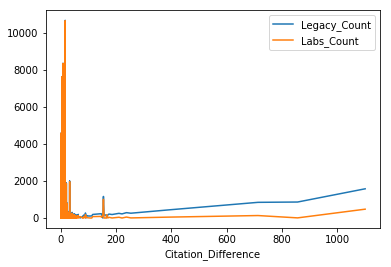

In [136]:
# For Non-Core
abs_diff_ext.loc[list(non_core_articles_with_diff)].sort_values('Citation_Difference', ascending=False).plot('Citation_Difference')

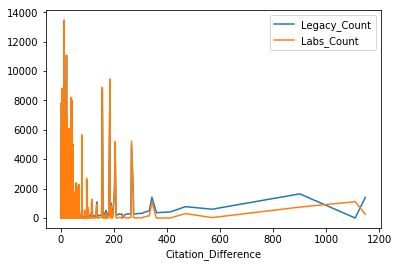

In [135]:
# For Core
abs_diff_ext.loc[list(core_articles_with_diff)].sort_values('Citation_Difference', ascending=False).plot('Citation_Difference')

### Analyze by "citeable"

In [128]:
citeable_list = pd.read_csv('inspire_citeable.txt', sep='\n', header=None)

In [132]:
citeable_articles_with_diff = np.intersect1d(abs_diff_ext.index, citeable_list[0].unique())
non_citeable_articles_with_diff = np.setxor1d(citeable_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are CITEABLE and {} are not Citeable'.format(len(abs_diff_ext), len(citeable_articles_with_diff), len(non_citeable_articles_with_diff)))

Of 79001 records with citation differences, 75620 are CITEABLE and 3381 are not Citeable


In [134]:
citeable_changed_citations = abs_diff_ext.loc[list(citeable_articles_with_diff)].Citation_Difference.sum()
non_citeable_changed_citations = abs_diff_ext.loc[list(non_citeable_articles_with_diff)].Citation_Difference.sum()

print('Of the above, CITEABLE records lose {} citations while not Citeable articles lose {} citations'.format(citeable_changed_citations, non_citeable_changed_citations))

Of the above, CITEABLE records lose 169691.0 citations while not Citeable articles lose 12029.0 citations


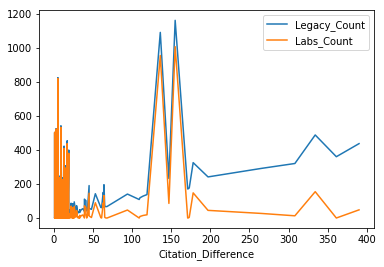

In [137]:
# For not Citeable
abs_diff_ext.loc[list(non_citeable_articles_with_diff)].sort_values('Citation_Difference', ascending=False).plot('Citation_Difference')

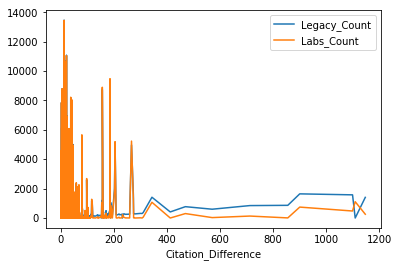

In [138]:
# For Citeable
abs_diff_ext.loc[list(citeable_articles_with_diff)].sort_values('Citation_Difference', ascending=False).plot('Citation_Difference')

# Please ignore after this
### Investiagte non-existent "cited" articles

In [26]:
non_overlapping = np.setdiff1d(np.union1d(records.oldRef.unique(), legacy.recID.unique()), np.intersect1d(records.oldRef.unique(), legacy.recID.unique()))
non_overlapping = non_overlapping[1:] # Remove entry for Zero

In [27]:
print('List from Legacy machine and from ES queries has {} non-overlapping records'.format(len(non_overlapping)))

List from Legacy machine and from ES queries has 5289 non-overlapping records


In [50]:
cited_in_dump_but_not_bibrank = []
cited_in_bibrank_but_not_dump = []
for article in non_overlapping:
    if len(records[records.oldRef == article]) != 0:
        cited_in_dump_but_not_bibrank.append(article)
    if len(legacy[legacy.recID == article]) != 0:
        cited_in_bibrank_but_not_dump.append(article)

In [100]:
cited_in_bibrank = legacy_indexed.loc[cited_in_bibrank_but_not_dump]

In [101]:
cited_in_dump = pd.DataFrame(records.oldRef.value_counts()[cited_in_dump_but_not_bibrank])
cited_in_dump.columns = ['Citation_Difference']